<a href="https://colab.research.google.com/github/colingwuyu/hedgingbox/blob/develop/examples/d4pg/d4pg_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install necessary dependencies.
!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[tf]
!pip install dm-acme[envs]


     |████████████████████████████████| 133kB 9.1MB/s 
ERROR: Operation cancelled by user
  Using cached https://files.pythonhosted.org/packages/4d/6c/e90a0837610aec772ae0b5ab5daeb3333f5b440fcb1c2bb7e368986ba44a/dm-acme-0.1.8.tar.gz
     |████████████████████████████████| 6.1MB 10.1MB/s 
     |████████████████████████████████| 322.8MB 54kB/s 
     |████████████████████████████████| 460kB 52.9MB/s 
     |████████████████████████████████| 6.8MB 52.7MB/s 
  Created wheel for dm-acme: filename=dm_acme-0.1.8-cp36-none-any.whl size=265911 sha256=1fa7fc26c2ede54d589de6ee58bef88d9ff9fb952dd27f8e1839d226abbcb11e
  Stored in directory: /root/.cache/pip/wheels/3d/b4/b7/e41339537d9433921ff26e8f9827b48052366c5125434825d7
Successfully built dm-acme
     |████████████████████████████████| 256kB 5.2MB/s 
     |████████████████████████████████| 102kB 6.6MB/s 
     |████████████████████████████████| 4.3MB 6.9MB/s 
     |████████████████████████████████| 18.6MB 150kB/s 
  Cloning git://github.com/deepmin

In [2]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
#@title Update HedgingBox
import os
project_folder = '/content/Projects'
hb_source = os.path.join(project_folder, 'HedgingBox')
%mkdir "$project_folder"
%cd "$project_folder"
!pwd
!mkdir -p 'ACME Models/QTable'
!git clone https://github.com/colingwuyu/HedgingBox.git
%cd HedgingBox
!git fetch --all
!git checkout -b develop origin/develop 
!git pull
import sys
sys.path.append(hb_source)

/content/Projects
/content/Projects
Cloning into 'HedgingBox'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 1218 (delta 15), reused 24 (delta 7), pack-reused 1179
Receiving objects: 100% (1218/1218), 11.85 MiB | 11.95 MiB/s, done.
Resolving deltas: 100% (728/728), done.
/content/Projects/HedgingBox
Fetching origin
Branch 'develop' set up to track remote branch 'develop' from 'origin'.
Switched to a new branch 'develop'
Already up to date.


In [4]:
#@title Import Modules
import acme
import dm_env
from acme import specs
from acme import datasets
from acme import wrappers
from acme.utils.loggers.csv import CSVLogger
from acme.adders import reverb as adders
from acme.tf import savers as tf2_savers
from acme.tf import networks as tf2_networks
from acme import types
from acme.tf import utils as tf2_utils
from acme.tf.losses.distributional import l2_project

import sonnet as snt

import reverb
import trfl

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Mapping, Sequence

import hb
from hb.market_env import hedging_market_env
from hb.market_env.pathgenerators import gbm_pathgenerator
from hb.market_env.rewardrules.pnl_reward import PnLReward, FwdPnLReward
from hb.market_env.rewardrules.pnl_qmeasure_reward import PnLQMeasureReward
from hb.market_env.rewardrules.sqrpenalty_reward import SquarePenaltyReward
from hb.market_env.rewardrules.pnl_intrinsic_reward import PnLIntrinsicReward
from hb.market_env.rewardrules.cash_flow_reward import CashFlowReward
from hb.market_env import market_specs
from hb.bots.d4pgbot.bot import D4PGBot
from hb.bots.deltabot.bot import DeltaHedgeBot
from hb.pricing import blackscholes

from absl import flags

In [5]:
#@title Training Environment Setup
trading_cost_pct =  0.0#@param {type:"number"}
kappa =  1.0#@param {type:"number"}
initial_price =  50#@param {type:"number"}
drift = 0.1 #@param {type:"number"}
sigma = 0.3 #@param {type:"number"}
number_steps =  90#@param {type:"integer"}
stock_price_lower_bound = 1 #@param {type:"integer"}
stock_price_upper_bound = 10000 #@param {type:"integer"}
stock_ticker_size = 1
option_holding =  -10#@param {type:"integer"}
initial_stock_holding =  5#@param {type:"integer"}
buy_sell_lots_bound =  4#@param {type:"integer"}
risk_free_rate = 0.02 #@param {type:"number"}
step_size = 1 #@param {type:"integer"}

step_size = step_size/360.
option_maturity = number_steps*step_size
atm_strike = initial_price*np.exp(risk_free_rate*option_maturity)
initial_option_price = blackscholes.price(True, initial_price, risk_free_rate,
                                          0., atm_strike, sigma, option_maturity,
                                          option_maturity)
gbm = gbm_pathgenerator.GBMGenerator(
            initial_price=initial_price, drift=drift,
            div=0.0, sigma=sigma, num_step=number_steps, 
            step_size=step_size, seed=1234
        )
gbm_pred = gbm_pathgenerator.GBMGenerator(
            initial_price=initial_price, drift=drift,
            div=0.0, sigma=sigma, num_step=number_steps, 
            step_size=step_size, seed=4321
        )
pnl_reward = PnLReward()
fwd_pnl_reward = FwdPnLReward()
intrinsic_reward = PnLIntrinsicReward()
cf_reward = CashFlowReward()
pnl_penalty_reward = SquarePenaltyReward(reward_rule=pnl_reward, scale_k=kappa)
fwd_pnl_penalty_reward = SquarePenaltyReward(reward_rule=fwd_pnl_reward, scale_k=kappa)
intrinsic_sqpenalty_reward = SquarePenaltyReward(reward_rule=intrinsic_reward, scale_k=kappa)
cf_sqpenalty_reward = SquarePenaltyReward(reward_rule=cf_reward, scale_k=kappa)
pnl_qmeasure_reward = PnLQMeasureReward(scale_k=kappa)
market_param = market_specs.MarketEnvParam(
    stock_ticker_size=0,
    stock_price_lower_bound=stock_price_lower_bound,
    stock_price_upper_bound=stock_price_upper_bound,
    lot_size=0,
    buy_sell_lots_bound=buy_sell_lots_bound,
    holding_lots_bound=np.infty)
environment = wrappers.SinglePrecisionWrapper(hedging_market_env.HedgingMarketEnv(
            stock_generator=gbm,
            reward_rule=pnl_reward,
            market_param=market_param,
            trading_cost_pct=trading_cost_pct,
            risk_free_rate=risk_free_rate,
            discount_rate=0.,
            option_maturity=option_maturity,
            option_strike=atm_strike,
            option_holding=option_holding,
            initial_stock_holding=initial_stock_holding,
        ))


In [6]:
def make_networks(
    action_spec: specs.BoundedArray,
    policy_layer_sizes: Sequence[int] = (256, 256, 256),
    critic_layer_sizes: Sequence[int] = (512, 512, 256),
    vmin: float = -150.,
    vmax: float = 150.,
    num_atoms: int = 51,
) -> Mapping[str, types.TensorTransformation]:
  """Creates networks used by the agent."""

  # Get total number of action dimensions from action spec.
  num_dimensions = np.prod(action_spec.shape, dtype=int)

  # Create the shared observation network; here simply a state-less operation.
  observation_network = tf2_utils.batch_concat

  # Create the policy network.
  policy_network = snt.Sequential([
      tf2_networks.LayerNormMLP(policy_layer_sizes, activate_final=True),
      tf2_networks.NearZeroInitializedLinear(num_dimensions),
      tf2_networks.TanhToSpec(action_spec),
  ])

  # Create the critic network.
  critic_network = snt.Sequential([
      # The multiplexer concatenates the observations/actions.
      tf2_networks.CriticMultiplexer(),
      tf2_networks.LayerNormMLP(critic_layer_sizes, activate_final=True),
      tf2_networks.DiscreteValuedHead(vmin, vmax, num_atoms),
  ])

  return {
      'policy': policy_network,
      'critic': critic_network,
      'observation': observation_network,
  }

In [7]:
#@title Create D4PG Hedging Bot
#@markdown ###Replay Buffer Param
batch_size =  256#@param {type:"integer"}
samples_per_insert =  32#@param {type:"integer"}
#@markdown ###Prediction Param
num_prediction_episodes =  1000#@param {type:"integer"}
train_episodes_per_pred =  1000#@param {type:"integer"}
model_name = "0tc_5h_10drift_2r_30sig_risk_obj" #@param {type:"string"}
create_new_model = False #@param {type:"boolean"}
risk_obj_func = True #@param {type:"boolean"}
risk_obj_c = 1.5 #@param {type:"number"}
flags.FLAGS.acme_id = 'D4PG/'+model_name
model_path = f"/content/gdrive/My Drive/Projects/ACME Models/D4PG/{model_name}/"
if not os.path.exists(model_path):
  os.makedirs(model_path)
model_chkpt = model_path + "checkpoint" 
if not os.path.exists(model_chkpt):
  os.makedirs(model_chkpt)
d4pg_bot_env_attr = ['remaining_time', 'stock_holding', 'stock_price',
                    'option_price', 'moneyness'
                    ]
environment.set_obs_attr(d4pg_bot_env_attr)
spec = specs.make_environment_spec(environment)
d4pg_networks = make_networks(spec.actions)

d4pg_bot = D4PGBot(
    environment_spec=spec,
    policy_network=d4pg_networks['policy'],
    critic_network=d4pg_networks['critic'],
    risk_obj_func=risk_obj_func,
    risk_obj_c=risk_obj_c,
    batch_size=batch_size,
    samples_per_insert=samples_per_insert,
    pred_episode=num_prediction_episodes,
    observation_per_pred=train_episodes_per_pred,
    pred_dir=model_path,
    checkpoint_subpath=model_path,
    checkpoint_per_min=30.
    )
d4pg_bot._checkpointer.save(force=True)

True

In [8]:
#@title D4PG Bot Train & Prediction
d4pg_bot._actor._actor._adder.reset()
environment.set_obs_attr(d4pg_bot_env_attr)
num_episodes =  train_episodes_per_pred + num_prediction_episodes
num_check_points =  40#@param {type:"integer"}
learning_rate =  1e-4#@param {type:"number"}
norm_sig = 0.3 #@param {type:"number"}
prediction = True #@param {type:"boolean"}
repeat_path = None

# update learning rate
d4pg_bot._learner._policy_optimizer.learning_rate = learning_rate
d4pg_bot._learner._critic_optimizer.learning_rate = learning_rate
# update exploration epsilon
d4pg_bot._actor._actor._policy_network = tf.function(
    snt.Sequential([
            d4pg_bot._learner._observation_network,
            d4pg_bot._learner._policy_network,
            tf2_networks.ClippedGaussian(norm_sig),
            tf2_networks.ClipToSpec(spec.actions),
        ])
)
environment.set_repeat_path(repeat_path)
d4pg_bot.set_pred_only(prediction)
if prediction:
  num_check_points = 1
# Try running the environment loop. We have no assertions here because all
# we care about is that the agent runs without raising any errors.
if num_episodes > 0:
  for i in range(num_check_points):
    print(f"Check Point {i}")
    # train
    environment.set_stock_generator(gbm)
    loop = acme.EnvironmentLoop(environment, d4pg_bot)
    if not prediction:
      loop.run(num_episodes=train_episodes_per_pred)
    # prediction
    gbm_pred.restart()
    environment.set_stock_generator(gbm_pred)
    loop.run(num_episodes=num_prediction_episodes)

Check Point 0
[Environment Loop] Episode Length = 90 | Episode Return = -661.687 | Episodes = 7 | Steps = 630 | Steps Per Second = 633.517
[Environment Loop] Episode Length = 90 | Episode Return = -1638.073 | Episodes = 14 | Steps = 1260 | Steps Per Second = 689.433
[Environment Loop] Episode Length = 90 | Episode Return = 1188.714 | Episodes = 21 | Steps = 1890 | Steps Per Second = 688.748
[Environment Loop] Episode Length = 90 | Episode Return = 813.668 | Episodes = 28 | Steps = 2520 | Steps Per Second = 657.094
[Environment Loop] Episode Length = 90 | Episode Return = 1392.284 | Episodes = 35 | Steps = 3150 | Steps Per Second = 652.045
[Environment Loop] Episode Length = 90 | Episode Return = 3204.570 | Episodes = 42 | Steps = 3780 | Steps Per Second = 635.255
[Environment Loop] Episode Length = 90 | Episode Return = -1036.598 | Episodes = 49 | Steps = 4410 | Steps Per Second = 675.985
[Environment Loop] Episode Length = 90 | Episode Return = 827.551 | Episodes = 56 | Steps = 5040 |

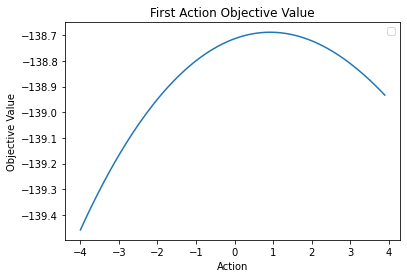

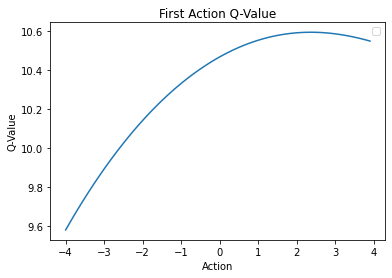

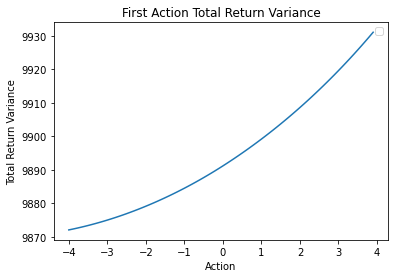

In [9]:
#@title First Action Q-Value
import tensorflow as tf
from acme.tf import utils as tf2_utils
observation = np.array([number_steps*step_size*360.,initial_stock_holding,
                        initial_price,
                        initial_option_price, 1.0
                        ],dtype=np.float32)
batched_obs = tf2_utils.add_batch_dim(observation)
act_arr = np.arange(-4.,4.,0.1, dtype=np.float32)
act = tf.constant(np.reshape(act_arr,(-1,1)))
batched_obs = tf.constant(np.tile(observation,[act.shape[0],1]))
# Forward the policy network.
firstaction_q_dist = d4pg_bot._learner._critic_network(batched_obs, act)
firstaction_q_mean = firstaction_q_dist.mean()
firstaction_q_var = firstaction_q_dist.variance()
obj_function_val = firstaction_q_mean - risk_obj_c * tf.pow(firstaction_q_var,0.5)
if risk_obj_func:
  firstaction_q = obj_function_val

  fig, ax = plt.subplots()
  fah = ax.plot(act_arr, firstaction_q.numpy())

  ax.set_ylabel('Objective Value')
  ax.set_xlabel('Action')
  ax.set_title('First Action Objective Value')

  ax.legend()
  plt.savefig(f'{model_path}firstaction_obj.png')
  plt.show()

  fig, ax = plt.subplots()
  fah = ax.plot(act_arr, firstaction_q_mean.numpy())

  ax.set_ylabel('Q-Value')
  ax.set_xlabel('Action')
  ax.set_title('First Action Q-Value')

  ax.legend()
  plt.savefig(f'{model_path}firstaction_q.png')
  plt.show()

  fig, ax = plt.subplots()
  fah = ax.plot(act_arr, firstaction_q_var.numpy())

  ax.set_ylabel('Total Return Variance')
  ax.set_xlabel('Action')
  ax.set_title('First Action Total Return Variance')

  ax.legend()
  plt.savefig(f'{model_path}firstaction_q_var.png')
  plt.show()

else:
  firstaction_q = firstaction_q_mean

  fig, ax = plt.subplots()
  fah = ax.plot(act_arr, firstaction_q.numpy())

  ax.set_ylabel('Q-Value')
  ax.set_xlabel('Action')
  ax.set_title('First Action Q-Value')

  ax.legend()
  plt.savefig(f'{model_path}firstaction.png')
  plt.show()

In [11]:
#@title Delta Hedging Bot Prediction
delta_bot_env_attr = ['remaining_time', 'option_holding', 'option_strike',
                      'interest_rate', 'stock_price', 'stock_dividend',
                      'stock_sigma', 'stock_holding', 'option_price']
environment.set_obs_attr(delta_bot_env_attr)
gbm_pred.restart()
environment.set_stock_generator(gbm_pred)
spec = specs.make_environment_spec(environment)
delta_pred_logger = CSVLogger(f'{model_path}/delta_pred',
                              label='delta_pred')
if os.path.exists(delta_pred_logger.file_path):
  os.remove(delta_pred_logger.file_path)
delta_bot = DeltaHedgeBot(environment_spec=spec,
                          pred_dir = model_path)
loop = acme.EnvironmentLoop(environment, delta_bot)
loop.run(num_episodes=num_prediction_episodes)

[Environment Loop] Episode Length = 90 | Episode Return = 9.215 | Episodes = 15 | Steps = 1350 | Steps Per Second = 481.698
[Environment Loop] Episode Length = 90 | Episode Return = 3.818 | Episodes = 29 | Steps = 2610 | Steps Per Second = 484.850
[Environment Loop] Episode Length = 90 | Episode Return = 2.078 | Episodes = 43 | Steps = 3870 | Steps Per Second = 475.726
[Environment Loop] Episode Length = 90 | Episode Return = 2.557 | Episodes = 57 | Steps = 5130 | Steps Per Second = 487.152
[Environment Loop] Episode Length = 90 | Episode Return = 3.859 | Episodes = 72 | Steps = 6480 | Steps Per Second = 1642.792
[Environment Loop] Episode Length = 90 | Episode Return = -0.531 | Episodes = 85 | Steps = 7650 | Steps Per Second = 478.232
[Environment Loop] Episode Length = 90 | Episode Return = 1.330 | Episodes = 99 | Steps = 8910 | Steps Per Second = 1575.424
[Environment Loop] Episode Length = 90 | Episode Return = 1.555 | Episodes = 113 | Steps = 10170 | Steps Per Second = 1639.546
[E

# PnL Distribution Status

In [12]:
d4pg_bot._predictor._update_progress_figures()
d4pg_hedge_status = d4pg_bot._predictor._progress_measures
delta_bot._predictor._update_progress_figures()
delta_hedge_status = delta_bot._predictor._progress_measures
print("D4PG Bot PnL mean %s" % str(d4pg_hedge_status['pnl_mean']))
print("D4PG Bot PnL std %s" % str(d4pg_hedge_status['pnl_std']))
print("D4PG Bot Mean Reward %s" % d4pg_hedge_status['reward_mean'])
print("D4PG Bot 5 Quantile %s" % d4pg_hedge_status['pnl_quantile_5'])
print("D4PG Bot 10 Quantile %s" % d4pg_hedge_status['pnl_quantile_10'])
print("Delta Bot PnL mean %s" % str(delta_hedge_status['pnl_mean']))
print("Delta Bot PnL std %s" % str(delta_hedge_status['pnl_std']))
print("Delta Bot Mean Reward %s" % delta_hedge_status['reward_mean'])
print("Delta Bot 5 Quantile %s" % delta_hedge_status['pnl_quantile_5'])
print("Delta Bot 10 Quantile %s" % delta_hedge_status['pnl_quantile_10'])

status_dic = {}

for k in d4pg_hedge_status.keys():
  status_dic[k] = [d4pg_hedge_status[k],delta_hedge_status[k]]

pd.DataFrame.from_dict(status_dic, orient="index", columns=["d4pg","delta"]).to_csv(f'{model_path}pnl_stat.csv')

D4PG Bot PnL mean 279.61329103959645
D4PG Bot PnL std 1546.7228420531276
D4PG Bot Mean Reward 279.587
D4PG Bot 5 Quantile -2172.839553995617
D4PG Bot 10 Quantile -1670.7169946875422
Delta Bot PnL mean 1.4908037287565539
Delta Bot PnL std 4.514475554472729
Delta Bot Mean Reward 1.484
Delta Bot 5 Quantile -6.026601389544789
Delta Bot 10 Quantile -3.954925025394186


In [13]:
train_perf = pd.read_csv(d4pg_bot._predictor._performance_logger.file_path)
delta_hedge_perf = pd.read_csv(delta_bot._predictor._performance_logger.file_path)

In [14]:
d4pg_pnl_list = train_perf[train_perf.type=='pnl'].drop(['path_num','type'], axis=1).sum(axis=1).values
delta_pnl_list = delta_hedge_perf[train_perf.type=='pnl'].drop(['path_num','type'], axis=1).sum(axis=1).values
d4pg_index_order = np.argsort(d4pg_pnl_list)

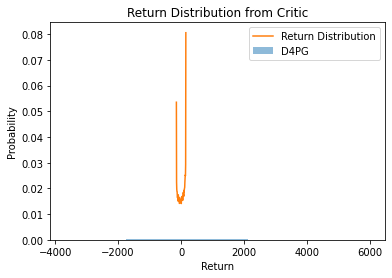

In [17]:
#@title Return Distribution From Critic
import tensorflow as tf
from acme.tf import utils as tf2_utils
observation = np.array([number_steps*step_size*360.,
                        initial_stock_holding,
                        initial_price,
                        initial_option_price, 1.0
                        ],dtype=np.float32)
batched_obs = tf2_utils.add_batch_dim(observation)
act = d4pg_bot._learner._policy_network(batched_obs)
q = d4pg_bot._learner._critic_network(batched_obs, act)
p = tf.nn.softmax(q.logits)

fig, ax = plt.subplots()

ax.hist(d4pg_pnl_list, bins=50, alpha=0.5, label='D4PG', density=True)
fah = ax.plot(q.values.numpy(), p.numpy()[0], label="Return Distribution")

ax.set_ylabel('Probability')
ax.set_xlabel('Return')
ax.set_title('Return Distribution from Critic')

ax.legend(loc='upper right')
plt.savefig(f'{model_path}dist2.png')
plt.show()


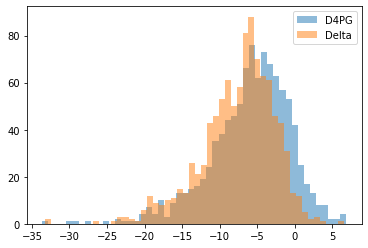

In [51]:
#@title P&L Distributions 
plt.hist(d4pg_pnl_list, bins=50, alpha=0.5, label='D4PG')
plt.hist(delta_pnl_list, bins=50, alpha=0.5, label='Delta')
plt.legend(loc='upper right')
plt.savefig(f'{model_path}dist.png')
plt.show()
np.save(f'{model_path}d4pg_pred_pnl.npy',d4pg_pnl_list)
np.save(f'{model_path}delta_pred_pnl.npy',delta_pnl_list)

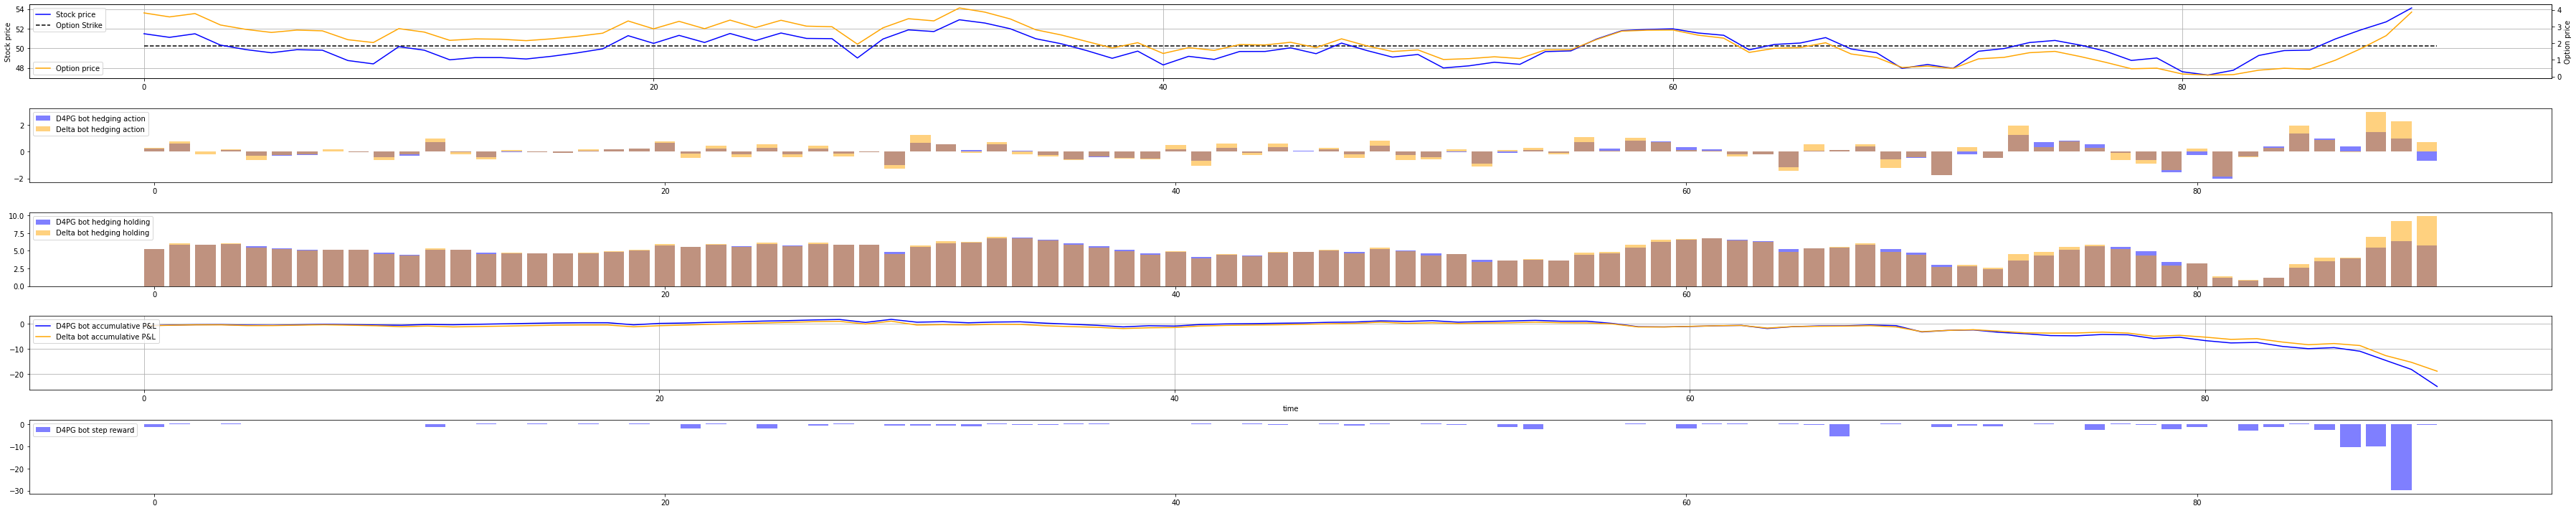

In [18]:
#@title One Path Prediction
pnl_order =  0#@param {type:"integer"}
path_num = d4pg_index_order[pnl_order]
d4pg_pnl_list = train_perf[train_perf.type=='pnl'].drop(['path_num','type'], axis=1).sum(axis=1)
delta_pnl_list = delta_hedge_perf[train_perf.type=='pnl'].drop(['path_num','type'], axis=1).sum(axis=1)

stock_price_path = train_perf[(train_perf.path_num==path_num)&(train_perf.type=='stock_price')].drop(['path_num','type'], axis=1)
option_price_path = delta_hedge_perf[(delta_hedge_perf.path_num==path_num)&(delta_hedge_perf.type=='option_price')].drop(['path_num','type'], axis=1)
d4pg_action_path = train_perf[(train_perf.path_num==path_num)&(train_perf.type=='action')].drop(['path_num','type'], axis=1)
delta_action_path = delta_hedge_perf[(delta_hedge_perf.path_num==path_num)&(delta_hedge_perf.type=='action')].drop(['path_num','type'], axis=1)
d4pg_cum_pnl_path = train_perf[(train_perf.path_num==path_num)&(train_perf.type=='pnl')].drop(['path_num','type'], axis=1)
delta_cum_pnl_path = delta_hedge_perf[(delta_hedge_perf.path_num==path_num)&(delta_hedge_perf.type=='pnl')].drop(['path_num','type'], axis=1)
d4pg_reward_path = train_perf[(train_perf.path_num==path_num)&(train_perf.type=='reward')].drop(['path_num','type'], axis=1)

stock_price_path.columns = stock_price_path.columns.astype(int) 
stock_price_path = pd.to_numeric(stock_price_path.reindex(sorted(stock_price_path.columns), axis=1).values[0])
option_price_path.columns = option_price_path.columns.astype(int) 
option_price_path = pd.to_numeric(option_price_path.reindex(sorted(option_price_path.columns), axis=1).values[0])
d4pg_action_path.columns = d4pg_action_path.columns.astype(int) 
d4pg_action_path = pd.to_numeric(d4pg_action_path.reindex(sorted(d4pg_action_path.columns), axis=1).values[0])
delta_action_path.columns = delta_action_path.columns.astype(int) 
delta_action_path = pd.to_numeric(delta_action_path.reindex(sorted(delta_action_path.columns), axis=1).values[0])
d4pg_cum_pnl_path.columns = d4pg_cum_pnl_path.columns.astype(int) 
d4pg_cum_pnl_path = np.cumsum(pd.to_numeric(d4pg_cum_pnl_path.reindex(sorted(d4pg_cum_pnl_path.columns), axis=1).values[0]))
delta_cum_pnl_path.columns = delta_cum_pnl_path.columns.astype(int) 
delta_cum_pnl_path = np.cumsum(pd.to_numeric(delta_cum_pnl_path.reindex(sorted(delta_cum_pnl_path.columns), axis=1).values[0]))
d4pg_cum_holding_path = np.cumsum(d4pg_action_path) + initial_stock_holding
delta_cum_holding_path = np.cumsum(delta_action_path) + initial_stock_holding
d4pg_reward_path = pd.to_numeric(d4pg_reward_path.reindex(sorted(d4pg_reward_path.columns), axis=1).values[0])

fig, axs = plt.subplots(5, 1,figsize=(50,10))
axs[0].plot(stock_price_path, label='Stock price', color='blue')
axs[0].grid(True)
axs[0].set_ylabel('Stock price')
axs[0].hlines(atm_strike, label='Option Strike', xmin=0, 
              xmax=len(stock_price_path), linestyles='dashed')
ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Option price') 
ax2.plot(option_price_path, label='Option price', color='orange')
axs[0].legend(loc='upper left')
ax2.legend(loc='lower left')

axs[1].bar(range(0, len(d4pg_action_path)), d4pg_action_path, color='blue', alpha=0.5, label='D4PG bot hedging action')
axs[1].bar(range(0, len(delta_action_path)), delta_action_path, color='orange', alpha=0.5, label='Delta bot hedging action')
axs[1].legend(loc='upper left')

axs[2].bar(range(0, len(d4pg_cum_holding_path)), d4pg_cum_holding_path, color='blue', alpha=0.5, label='D4PG bot hedging holding')
axs[2].bar(range(0, len(delta_cum_holding_path)), delta_cum_holding_path, color='orange', alpha=0.5, label='Delta bot hedging holding')
axs[2].legend(loc='upper left')

axs[3].plot(d4pg_cum_pnl_path, color='blue', label='D4PG bot accumulative P&L')
axs[3].plot(delta_cum_pnl_path, color='orange', label='Delta bot accumulative P&L')
axs[3].grid(True)
axs[3].legend(loc='upper left')
axs[3].set_xlabel('time')

axs[4].bar(range(0, len(d4pg_reward_path)), d4pg_reward_path, color='blue', alpha=0.5, label='D4PG bot step reward')
axs[4].legend(loc='upper left')

fig.tight_layout()
plt.savefig(f'{model_path}price_action_prediction_sample{pnl_order}.png')
plt.show()

In [19]:
train_progress = pd.read_csv(d4pg_bot._predictor._progress_logger.file_path)[2:]
delta_bot._predictor._update_progress_figures()
delta_hedge_status = delta_bot._predictor._progress_measures

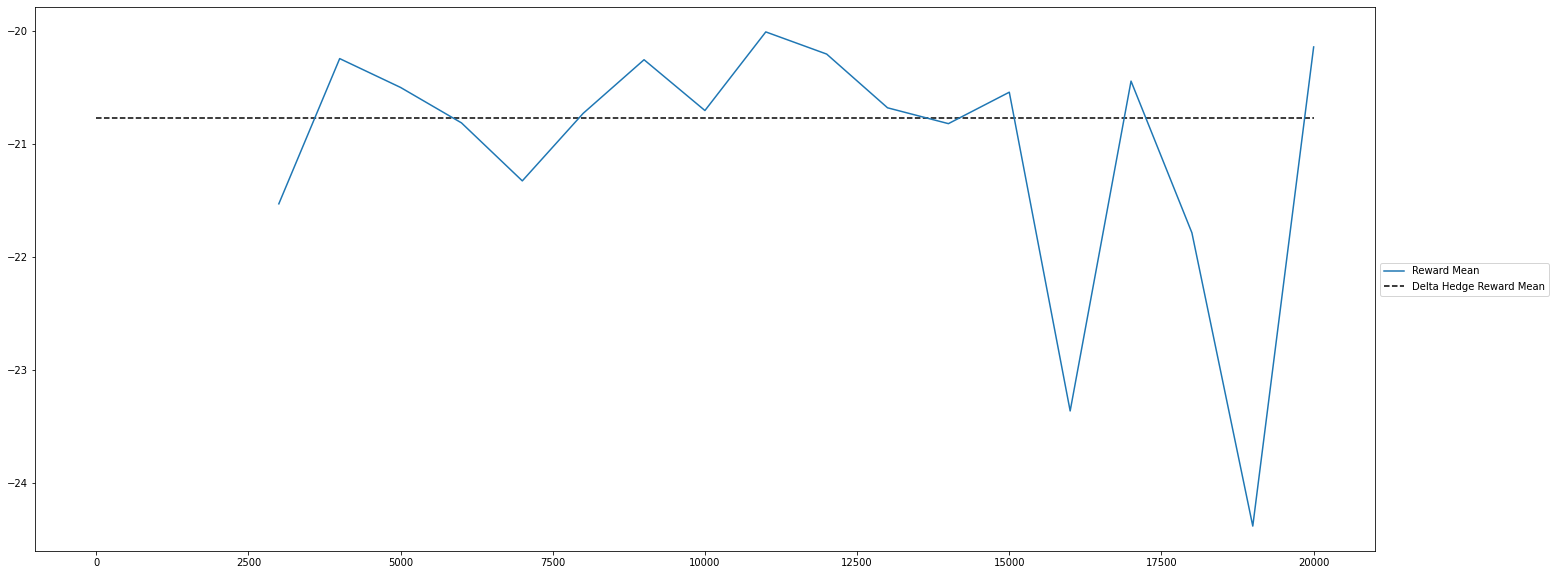

In [20]:
fig = plt.figure(figsize=(30,10))
ax = plt.subplot(111)
ax.plot(train_progress['train_episodes'], train_progress['reward_mean'], label='Reward Mean')
ax.hlines(delta_hedge_status['reward_mean'], label='Delta Hedge Reward Mean', xmin=0, 
          xmax=train_progress['train_episodes'].max(), linestyles='dashed')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'{model_path}reward.png')
plt.show()

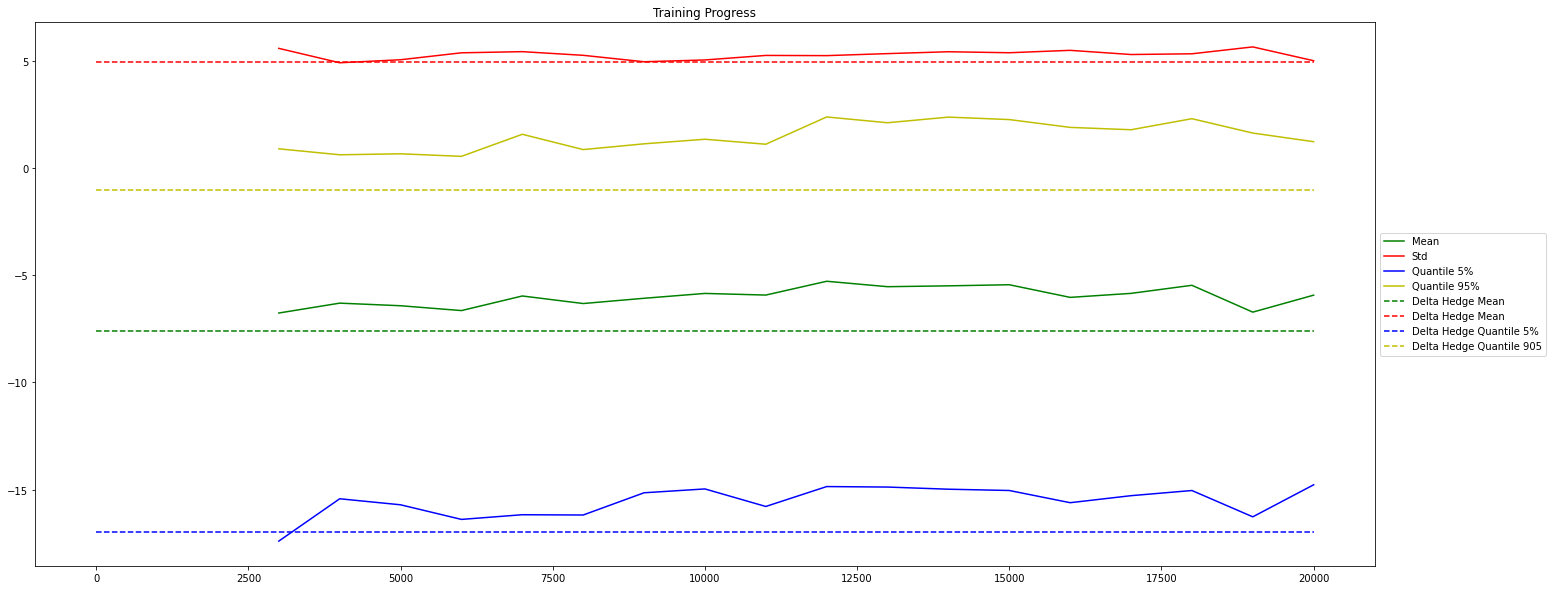

In [21]:
fig = plt.figure(figsize=(30,10))
ax = plt.subplot(111)

pred_count = train_progress['train_episodes']
ax.plot(pred_count, train_progress['pnl_mean'], label='Mean', color='g')
ax.plot(pred_count, train_progress['pnl_std'], label='Std', color='r')
ax.plot(pred_count, train_progress['pnl_quantile_5'], label='Quantile 5%', color='b')
ax.plot(pred_count, train_progress['pnl_quantile_95'], label='Quantile 95%', color='y')
ax.hlines(delta_hedge_status['pnl_mean'], label='Delta Hedge Mean', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors='g')
ax.hlines(delta_hedge_status['pnl_std'], label='Delta Hedge Mean', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors='r')
ax.hlines(delta_hedge_status['pnl_quantile_5'], label='Delta Hedge Quantile 5%', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors='b')
ax.hlines(delta_hedge_status['pnl_quantile_95'], label='Delta Hedge Quantile 905', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors='y')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Training Progress')
plt.savefig(f'{model_path}quantiles.png')
plt.show()

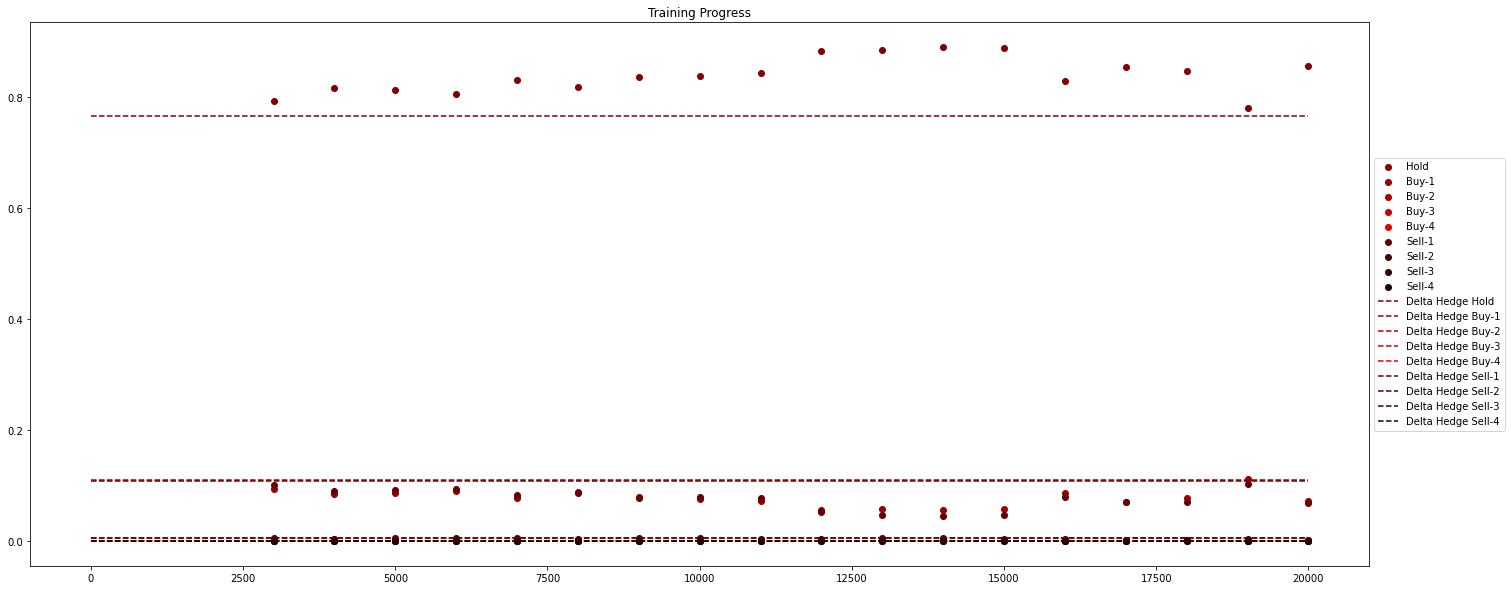

In [22]:
fig = plt.figure(figsize=(30,10))
ax = plt.subplot(111)

pred_count = train_progress['train_episodes']
ax.scatter(pred_count, train_progress['hold'], label='Hold', color=(0.5,0,0))
ax.scatter(pred_count, train_progress['buy-1'], label='Buy-1', color=(0.6,0,0))
ax.scatter(pred_count, train_progress['buy-2'], label='Buy-2', color=(0.7,0,0))
ax.scatter(pred_count, train_progress['buy-3'], label='Buy-3', color=(0.8,0,0))
ax.scatter(pred_count, train_progress['buy-4'], label='Buy-4', color=(0.9,0,0))
ax.scatter(pred_count, train_progress['sell-1'], label='Sell-1', color=(0.4,0,0))
ax.scatter(pred_count, train_progress['sell-2'], label='Sell-2', color=(0.3,0,0))
ax.scatter(pred_count, train_progress['sell-3'], label='Sell-3', color=(0.2,0,0))
ax.scatter(pred_count, train_progress['sell-4'], label='Sell-4', color=(0.1,0,0))
ax.hlines(delta_hedge_status['hold'], label='Delta Hedge Hold', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.5,0,0))
ax.hlines(delta_hedge_status['buy-1'], label='Delta Hedge Buy-1', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.6,0,0))
ax.hlines(delta_hedge_status['buy-2'], label='Delta Hedge Buy-2', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.7,0,0))
ax.hlines(delta_hedge_status['buy-3'], label='Delta Hedge Buy-3', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.8,0,0))
ax.hlines(delta_hedge_status['buy-4'], label='Delta Hedge Buy-4', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.9,0,0))
ax.hlines(delta_hedge_status['sell-1'], label='Delta Hedge Sell-1', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.4,0,0))
ax.hlines(delta_hedge_status['sell-2'], label='Delta Hedge Sell-2', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.3,0,0))
ax.hlines(delta_hedge_status['sell-3'], label='Delta Hedge Sell-3', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.2,0,0))
ax.hlines(delta_hedge_status['sell-4'], label='Delta Hedge Sell-4', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.1,0,0))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Training Progress')
plt.show()

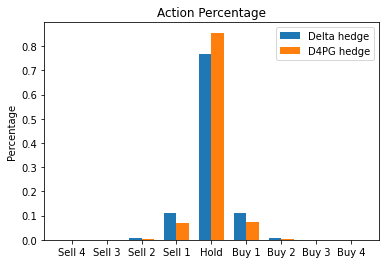

In [23]:
labels = ['Sell 4', 'Sell 3', 'Sell 2', 'Sell 1', 'Hold', 'Buy 1', 'Buy 2', 'Buy 3', 'Buy 4']
ind = ['sell-4','sell-3','sell-2','sell-1','hold', 'buy-1','buy-2','buy-3','buy-4']
delta_hedge_actions = np.array([delta_hedge_status[k] for k in ind])
qtable_hedge_actions = train_progress[['sell-4','sell-3','sell-2','sell-1','hold', 'buy-1','buy-2','buy-3','buy-4']].iloc[-1]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
deltah = ax.bar(x - width/2, delta_hedge_actions, width, label='Delta hedge')
qtableh = ax.bar(x + width/2, qtable_hedge_actions, width, label='D4PG hedge')

ax.set_ylabel('Percentage')
ax.set_title('Action Percentage')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend()
plt.savefig(f'{model_path}action.png')
plt.show()

In [ ]:
#@title First step
d4pg_bot._actor._actor._adder.reset()
timestep = environment.reset()
d4pg_bot._actor.observe_first(timestep)
print(timestep.observation)

[90.         5.        50.         2.9892645  1.         0.       ]


In [ ]:
#@title Mid Actor step
action = d4pg_bot._predictor.select_action(timestep.observation)
next_timestep = environment.step(action)

# Record the transition.
d4pg_bot._actor.observe(action=action, next_timestep=next_timestep)
print(action)
print(next_timestep.observation)

[-0.01996064]
[85.         6.6661863 48.577164   2.2028568  0.9712734  2.5680192]


In [ ]:
d4pg_bot._actor._actor._policy_network._layers

ListWrapper([TransformationWrapper(transformation=<function identity at 0x7fb0c9c1ebf8>), Sequential(
    layers=[LayerNormMLP(layer_sizes=(256, 256, 256), activate_final=True),
            NearZeroInitializedLinear(output_size=1),
            TanhToSpec(
               spec=BoundedArray(shape=(1,), dtype=dtype('float32'), name='market_action', minimum=[-4.], maximum=[4.]),
           )],
), ClippedGaussian(stddev=0.3), ClipToSpec(
    spec=BoundedArray(shape=(1,), dtype=dtype('float32'), name='market_action', minimum=[-4.], maximum=[4.]),
)])